In [ ]:
!pip install pandapower
!pip install python-igraph

In [84]:
import pandas as pd
import pandapower as pp
import numpy as np
import copy


In [85]:
# This is a dummy grid that will be used as experimentation object

def create_net(houses=3, f_l=1, f_pv=1):
    """
    f_1: Factor for scaling the loads (Too big netwokrs require lower loads for
          the network to function)
    f_pv: Factor for scaling the PVs Gens (To produce overvoltages)

    Simple net that looks like:

    ext_grid b0
    |
    b1
    |
    trafo(10/0.4)
    |
    b2
    |
    b3--------------b4 -------------b5-------------and more elements
    |               |               |
    |-----|----|    |-----|-----|   |-----|-----|
    load  sto  PV   load  sto  PV   load  sto  PV
    """
    net = pp.create_empty_network()

    b0 = pp.create_bus(net, vn_kv=10, name="bus0_grid")
    b1 = pp.create_bus(net, vn_kv=10, name="bus1_trafo_hv" )
    b2 = pp.create_bus(net, vn_kv=0.4, name="bus2_trafo_lv")
    
    # houses_buses__list
    hbl=[]
    for i in range(houses):
      b = pp.create_bus(net, vn_kv=0.4, name=f"bus_house_{i}")
      hbl.append(b)

    # External grid
    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 0.20, "34-AL1/6-ST1A 10.0")

    # Transformer
    pp.create_transformer(net, b1, b2, "0.4 MVA 10/0.4 kV", name='tr1')
    
    # Line for the first house
    pp.create_line(net, b2, hbl[0], 0.20, "34-AL1/6-ST1A 10.0")

    # Line for from the n house to the n+1 house
    for i in range(houses-1):
      pp.create_line(net, hbl[i], hbl[i+1], 0.20, "94-AL1/15-ST1A 0.4")
    
    # Create the elements of the buses
    # Load starts at 30, 40, 50 kW
    # SGens are PVs and go from 10,15,20 kW
    # Storages are assumed to be at 50% and can charge or discharge

    for i,b in enumerate(hbl):
        pp.create_load(net, b, p_mw=(30 + 10 * i)*f_l, q_mvar=0,
                       name=f'load{i}', scaling=1 / 1000)
        pp.create_sgen(net, b, p_mw=(10 + 5 * i)*f_pv, q_mvar=0,
                       name=f'sgen{i}', scaling=1 / 1000)
        pp.create_storage(net, bus=b, p_mw=0, q_mvar=0, max_e_mwh=1000, 
                          name=f'storage{i}', scaling=1 / 1000)

    return net
  


In [86]:
# Create a dummy grid to see the problems
# The number of houses can be modified for larger grids.
# If it not converges, reduce the size of the loads with "f_l=0.5"
net = create_net(5, f_l=0.66)
pp.runpp(net)
net.res_bus

vm_pu  va_degree      p_mw    q_mvar
0  1.000000   0.000000 -0.075094 -0.005977
1  0.999870  -0.002524  0.000000  0.000000
2  0.996853  -0.395719  0.000000  0.000000
3  0.917427  -2.121235  0.009800  0.000000
4  0.892161  -3.522116  0.011400  0.000000
5  0.872239  -4.691235  0.013000  0.000000
6  0.858299  -5.545762  0.014600  0.000000
7  0.850989  -6.006431  0.016200  0.000000

In [87]:
# See the Jacobian Matrix
jacobian = net._ppc["internal"]["J"].todense()
   

In [88]:
# This provides a vector that represents the [d_d || d_V] vector to multiply with
# the Jacobian Matrix
# calculate the d_V for each node
# the first portion corresponds to d_d =0 for all values
# The first bus (slack) is always ommited
list_v = [0]*(len(net.res_bus["vm_pu"])-1)

# For the other buses, see that no limits are violeted
# The Jacobian Matrix is NOT vm_pu, but in V. Then an escalation is required

for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
    if v < 0.95:
        dv = (0.95 - v)*400
    elif v > 1.05:
        dv = (1.05 - v)*400
    else:
        dv = 0
    list_v.append(dv)
list_v

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 13.029363436481045,
 23.135559369394578,
 31.104430878578437,
 36.680507968469115,
 39.6042060427741]

In [89]:
# Matrix with the dela Ps and the delta Qs
#[d_P d_Q] = [Jacobian][d_d || d_V]
deltas_mx = np.dot(jacobian, list_v)
print(np.around(deltas_mx[0], 2))

# Here one can read the required P in each of the busses

[[  0.   -10.36  -2.56   2.71   2.51   2.35   2.35   0.    -4.85  -8.64
    2.11   2.64   3.15   3.59]]


In [90]:
# The values of deltas_mx correspond to the buses (outside the slack)
# The transformer bus can be overlooked as it is the bus of the sum
# Change the values of P as output of the batteries
net2 = copy.deepcopy(net)
for i in net2.storage.index:
 net2.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]

pp.runpp(net2)
net2.res_bus



vm_pu  va_degree      p_mw    q_mvar
0  1.000000   0.000000 -0.065136 -0.004179
1  0.999888  -0.002285  0.000000  0.000000
2  0.997365  -0.344721  0.000000  0.000000
3  0.929008  -1.879374  0.012360  0.000000
4  0.908905  -2.993243  0.008688  0.000000
5  0.892753  -3.929920  0.010493  0.000000
6  0.881282  -4.618925  0.012246  0.000000
7  0.875209  -4.991970  0.013853  0.000000

In [91]:
# The first iteration does not produces enough results. 
# This is because the Qs were not considered

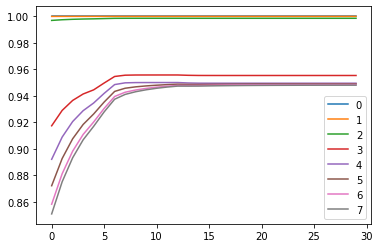

In [92]:
# Implement the previous as loop to see how it converges
net = create_net(5, f_l=0.66)
pp.runpp(net)

# Dataframe to save each iteration
bus_res=pd.DataFrame()
bus_res[0]=net.res_bus["vm_pu"]
k=1
while k<30:
  jacobian = net._ppc["internal"]["J"].todense()
  list_v = [0]*(len(net.res_bus["vm_pu"])-1)

  for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
      if v < 0.95:
          dv = (0.95 - v)*400
      elif v > 1.05:
          dv = (1.05 - v)*400
      else:
          dv = 0
      list_v.append(dv)

  deltas_mx = np.dot(jacobian, list_v)
  for i in net.storage.index:
    # here a limit can be implemented
    lim = 15
    if net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]>lim:
      net.storage.at[i,"p_mw"]=lim
    
    elif net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]<-lim:
      net.storage.at[i,"p_mw"]=-lim
    else:
      net.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]

  pp.runpp(net)
  net.res_bus
  bus_res[k]=net.res_bus["vm_pu"]
  k+=1

bus_res.T.plot()

In [93]:
# See the final results of the required storage
# Limits are respected
net.storage


name  bus       p_mw  q_mvar  ...  max_e_mwh  scaling  in_service  type
0  storage0    3  15.000000     0.0  ...     1000.0    0.001        True  None
1  storage1    4   1.795047     0.0  ...     1000.0    0.001        True  None
2  storage2    5 -12.987191     0.0  ...     1000.0    0.001        True  None
3  storage3    6 -14.582588     0.0  ...     1000.0    0.001        True  None
4  storage4    7 -15.000000     0.0  ...     1000.0    0.001        True  None

[5 rows x 11 columns]

In [94]:
# Final Bus Results
net.res_bus

vm_pu  va_degree      p_mw    q_mvar
0  1.000000   0.000000 -0.042090 -0.000951
1  0.999929  -0.001643  0.000000  0.000000
2  0.998463  -0.225049  0.000000  0.000000
3  0.955340  -1.282483  0.024800  0.000000
4  0.949512  -1.612785  0.013195  0.000000
5  0.949015  -1.641148  0.000013  0.000000
6  0.948524  -1.669242  0.000017  0.000000
7  0.948039  -1.696960  0.001200  0.000000

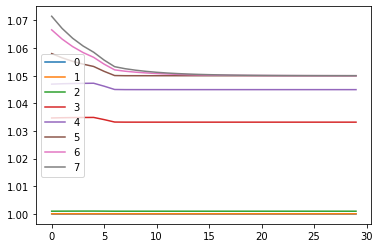

In [101]:
# Now the same idea but with an excess of PV to produce overvoltages
# Implement the previous as loop to see how it converges
net = create_net(5, f_l=0.66, f_pv=2)
pp.runpp(net)

# Dataframe to save each iteration
bus_res=pd.DataFrame()
bus_res[0]=net.res_bus["vm_pu"]
k=1
while k<30:
  jacobian = net._ppc["internal"]["J"].todense()
  list_v = [0]*(len(net.res_bus["vm_pu"])-1)

  for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
      if v < 0.95:
          dv = (0.95 - v)*400
      elif v > 1.05:
          dv = (1.05 - v)*400
      else:
          dv = 0
      list_v.append(dv)

  deltas_mx = np.dot(jacobian, list_v)
  for i in net.storage.index:
    # here a limit can be implemented
    lim = 15
    if net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]>lim:
      net.storage.at[i,"p_mw"]=lim
    elif net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]<-lim:
      net.storage.at[i,"p_mw"]=-lim
    else:
      net.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]

  pp.runpp(net)
  net.res_bus
  bus_res[k]=net.res_bus["vm_pu"]
  k+=1

bus_res.T.plot()


In [103]:
# This indicates that the PV needs to be stored
net.storage

name  bus       p_mw  q_mvar  ...  max_e_mwh  scaling  in_service  type
0  storage0    3   0.000000     0.0  ...     1000.0    0.001        True  None
1  storage1    4 -15.000000     0.0  ...     1000.0    0.001        True  None
2  storage2    5  -6.815101     0.0  ...     1000.0    0.001        True  None
3  storage3    6  10.389340     0.0  ...     1000.0    0.001        True  None
4  storage4    7  13.786441     0.0  ...     1000.0    0.001        True  None

[5 rows x 11 columns]

In [105]:
net.res_bus

vm_pu  va_degree      p_mw    q_mvar
0  1.000000   0.000000  0.030209 -0.000876
1  1.000050   0.001333  0.000000  0.000000
2  1.000982   0.168828  0.000000  0.000000
3  1.033203   0.995448 -0.000200  0.000000
4  1.044969   1.619491 -0.018600  0.000000
5  1.050000   1.881455 -0.013815  0.000000
6  1.050009   1.881907 -0.000011  0.000000
7  1.050014   1.882161 -0.000014  0.000000

In [131]:
# A grid with over and underload?
# Need another grid
def create_mixed_grid(houses,f_l=1,f_pv=1):
    net = pp.create_empty_network()

    b0 = pp.create_bus(net, vn_kv=10, name="bus0_grid",geodata= (0,0))
    b1 = pp.create_bus(net, vn_kv=10, name="bus1_trafo_hv",geodata= (0,1) )
    b2 = pp.create_bus(net, vn_kv=0.4, name="bus2_trafo_lv",geodata= (0,2))
    
    # houses_buses__list
    hbl=[]
    for i in range(houses):
      b = pp.create_bus(net, vn_kv=0.4, name=f"bus_house_{i}",geodata= (1,i+2))
      hbl.append(b)
    
 

    # External grid
    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 0.20, "34-AL1/6-ST1A 10.0")

    # Transformer
    pp.create_transformer(net, b1, b2, "0.4 MVA 10/0.4 kV", name='tr1')
    
    # Line for the first house
    pp.create_line(net, b2, hbl[0], 0.20, "34-AL1/6-ST1A 10.0")

    # Create Line for the n/2 house
    pp.create_line(net, b2, hbl[int(houses/2)], 0.20, "34-AL1/6-ST1A 10.0")
   
    # Line for from the n house to the n+1 house
    for i in range(int(houses/2)-1):
      pp.create_line(net, hbl[i], hbl[i+1], 0.20, "94-AL1/15-ST1A 0.4")
    
    for i in range(int(houses/2),houses-1):
      pp.create_line(net, hbl[i], hbl[i+1], 0.20, "94-AL1/15-ST1A 0.4")

    # Create the elements of the buses
    # Load starts at 30, 40, 50 kW
    # SGens are PVs and go from 10,15,20 kW
    # Storages are assumed to be at 50% and can charge or discharge

    for i,b in enumerate(hbl):
        pp.create_load(net, b, p_mw=(30 + 0 * i)*f_l, q_mvar=0,
                       name=f'load{i}', scaling=1 / 1000)

        pp.create_storage(net, bus=b, p_mw=0, q_mvar=0, max_e_mwh=1000, 
                          name=f'storage{i}', scaling=1 / 1000)
        if i>=houses/2:
          pp.create_sgen(net, b, p_mw=(20 + 5 * i)*f_pv, q_mvar=0,
                  name=f'sgen{i}', scaling=1 / 1000)

    return net




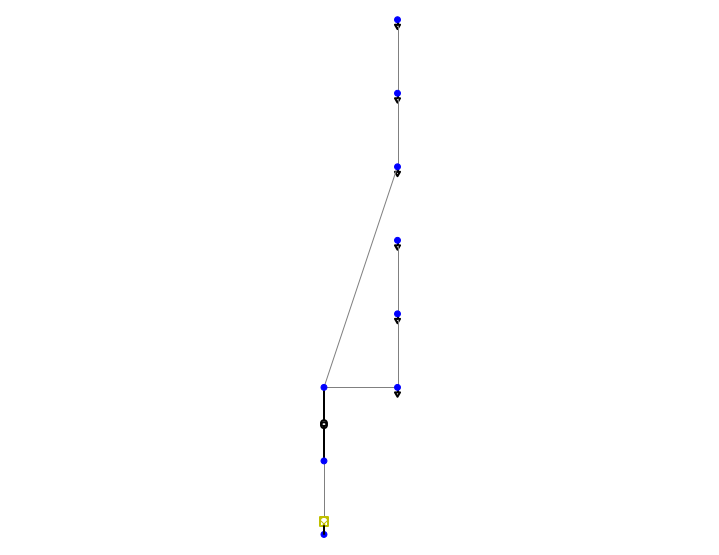

In [132]:
net = create_mixed_grid(6)
import pandapower.plotting as plot
plot.simple_plot(net, show_plot=True, plot_loads=True)

In [ ]:
# This is to find which values of scaling provide convergence. Skipping
# vals= np.arange(0.2, 3, 0.2).tolist()
# for i,j in zip(vals,vals):
#   net = create_mixed_grid(8,i,j)
#   try:
#     pp.runpp(net)
#     print(i,j)
#     print(net.res_bus)
#   except:
#     pass


In [142]:
net =create_mixed_grid(8,0.8,0.8)
pp.runpp(net)
net.res_bus

vm_pu  va_degree      p_mw    q_mvar
0   1.000000   0.000000 -0.063763 -0.013193
1   0.999884  -0.001367  0.000000  0.000000
2   0.996553  -0.319465  0.000000  0.000000
3   0.872974  -3.000950  0.024000  0.000000
4   0.838096  -5.045331  0.024000  0.000000
5   0.814993  -6.505061  0.024000  0.000000
6   0.803496  -7.266295  0.024000  0.000000
7   1.050028   1.099045 -0.008000  0.000000
8   1.066737   1.989122 -0.012000  0.000000
9   1.079339   2.638540 -0.016000  0.000000
10  1.086360   2.992806 -0.020000  0.000000

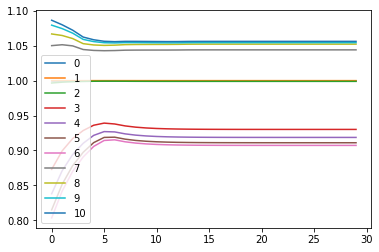

In [143]:
# Dataframe to save each iteration
bus_res=pd.DataFrame()
bus_res[0]=net.res_bus["vm_pu"]
k=1
while k<30:
  jacobian = net._ppc["internal"]["J"].todense()
  list_v = [0]*(len(net.res_bus["vm_pu"])-1)

  for v in net.res_bus["vm_pu"][1:]:  # 0 is always the slack
      if v < 0.95:
          dv = (0.95 - v)*400
      elif v > 1.05:
          dv = (1.05 - v)*400
      else:
          dv = 0
      list_v.append(dv)

  deltas_mx = np.dot(jacobian, list_v)
  for i in net.storage.index:
    # here a limit can be implemented
    lim = 15
    if net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]>lim:
      net.storage.at[i,"p_mw"]=lim
    elif net.storage.at[i,"p_mw"]-deltas_mx[0,i+2]<-lim:
      net.storage.at[i,"p_mw"]=-lim
    else:
      net.storage.at[i,"p_mw"]-=deltas_mx[0,i+2]

  pp.runpp(net)
  net.res_bus
  bus_res[k]=net.res_bus["vm_pu"]
  k+=1

bus_res.T.plot()

In [144]:
# Interestingly, in this case the limit is insufficient to provide a solution,
# but the effects are minimized.
net.res_storage

p_mw  q_mvar
0  0.00923     0.0
1 -0.01500     0.0
2 -0.01500     0.0
3 -0.01500     0.0
4 -0.01500     0.0
5 -0.00461     0.0
6  0.01500     0.0
7  0.01500     0.0